In [26]:
import pandas as pd
import numpy as np
import json
import os
import pathlib
import warnings
from joblib import load

# Variable combinations
from itertools import combinations_with_replacement

# ML models
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, DMatrix, cv
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from mplsoccer import Pitch
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
notebook_dir = pathlib.Path().absolute()
events_path = os.path.join(notebook_dir,"wyscout_data", "events_data")

df = pd.DataFrame()

# Get all JSON files in the directory
json_files = [f for f in os.listdir(events_path) if f.endswith('.json')]

# Load each file and concatenate to the dataframe
for file_name in json_files:
    path = os.path.join(events_path, file_name)
    with open(path) as f:
        data = json.load(f)
    df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)

df = df.reset_index()
df.head()

,index,id,matchId,matchPeriod,minute,second,matchTimestamp,videoTimestamp,relatedEventId,type,...,team,opponentTeam,player,pass,shot,groundDuel,aerialDuel,infraction,carry,possession
0,0,2384313747,5588197,1H,0,2,00:00:02.559,3.559115,2.384314e+09,"{'primary': 'pass', 'secondary': ['back_pass',...",...,"{'id': 1624, 'name': 'Tottenham Hotspur'}","{'id': 1625, 'name': 'Manchester City'}","{'id': 286831, 'name': 'D. Solanke', 'position...","{'accurate': True, 'angle': -159, 'height': No...",None,None,None,None,None,"{'id': 2384313747, 'duration': '9.752984', 'ty..."
1,1,2384313748,5588197,1H,0,4,00:00:04.324,5.324929,2.384314e+09,"{'primary': 'pass', 'secondary': ['lateral_pas...",...,"{'id': 1624, 'name': 'Tottenham Hotspur'}","{'id': 1625, 'name': 'Manchester City'}","{'id': 413582, 'name': 'Y. Bissouma', 'positio...","{'accurate': True, 'angle': 62, 'height': None...",None,None,None,None,None,"{'id': 2384313747, 'duration': '9.752984', 'ty..."
2,2,2384313771,5588197,1H,0,6,00:00:06.973,7.973209,2.384314e+09,"{'primary': 'pass', 'secondary': ['lateral_pas...",...,"{'id': 1624, 'name': 'Tottenham Hotspur'}","{'id': 1625, 'name': 'Manchester City'}","{'id': 551442, 'name': 'Pedro Porro', 'positio...","{'accurate': True, 'angle': -95, 'height': Non...",None,None,None,None,None,"{'id': 2384313747, 'duration': '9.752984', 'ty..."
3,3,2384313772,5588197,1H,0,8,00:00:08.768,9.768278,2.384314e+09,"{'primary': 'pass', 'secondary': ['back_pass',...",...,"{'id': 1624, 'name': 'Tottenham Hotspur'}","{'id': 1625, 'name': 'Manchester City'}","{'id': 413582, 'name': 'Y. Bissouma', 'positio...","{'accurate': True, 'angle': -135, 'height': No...",None,None,None,None,None,"{'id': 2384313747, 'duration': '9.752984', 'ty..."
4,4,2384313775,5588197,1H,0,10,00:00:10.769,11.769625,2.384314e+09,"{'primary': 'pass', 'secondary': ['forward_pas...",...,"{'id': 1624, 'name': 'Tottenham Hotspur'}","{'id': 1625, 'name': 'Manchester City'}","{'id': 136441, 'name': 'B. Davies', 'position'...","{'accurate': True, 'angle': 32, 'height': None...",None,None,None,None,None,"{'id': 2384313747, 'duration': '9.752984', 'ty..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480511 entries, 0 to 480510
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           480511 non-null  int64  
 1   id              480511 non-null  int64  
 2   matchId         480511 non-null  int64  
 3   matchPeriod     480511 non-null  object 
 4   minute          480511 non-null  int64  
 5   second          480511 non-null  int64  
 6   matchTimestamp  480511 non-null  object 
 7   videoTimestamp  480511 non-null  object 
 8   relatedEventId  452956 non-null  float64
 9   type            480511 non-null  object 
 10  location        480150 non-null  object 
 11  team            480511 non-null  object 
 12  opponentTeam    480511 non-null  object 
 13  player          480511 non-null  object 
 14  pass            274869 non-null  object 
 15  shot            6971 non-null    object 
 16  groundDuel      77664 non-null   object 
 17  aerialDuel

# Preparing the data for possession chains

We'll analyse passes that happened 15 seconds before a shot later but it doesn't make a lot of sense to assign xG and quickShot values to shots from previous possession chains.

For example: we have the ball and play some passes, we lose the ball, recover, make some other passes and finally shoot at goal. To me that process describes two different possession chains where only the second one really contributes to the shot/goal. But if those events happen close to each other, passes from the first chain would get xG and quickShot values. Which isn't correct in my opinion.


In [4]:
# Split the type column
df["primaryType"] = df["type"].apply(lambda x: x["primary"] if isinstance(x, dict) else None)
df["secondaryType"] = df["type"].apply(lambda x: x["secondary"] if isinstance(x, dict) else [])

# Set team id column
df["teamId"] = df["team"].apply(lambda x: x["id"])

# Look at next event
next_event = df.shift(-1, fill_value=0)
df["nextPrimaryType"] = next_event["primaryType"]
df["nextSecondaryType"] = next_event["secondaryType"]
df["nextTeamId"] = next_event["team"].apply(lambda x: x["id"] if isinstance(x, dict) else x)
df["kickedOut"] = df["nextSecondaryType"].apply(lambda x: 'ball_out' in x if isinstance(x, list) else False)
print(f"Init: {df.shape}")

# Drop when nextTeam is 0
df = df[df["nextTeamId"] != None]
print(f"Dropped when nextTeam is 0: {df.shape}")

# Drop game interruptions
df = df[~df["primaryType"].isin(["game_interruption"])]
print(f"Dropped game interruptions: {df.shape}")

# Drop lost duels
df = df[~((df["primaryType"] == "duel") & (df["secondaryType"].apply(lambda x: "loss" in x)))]
print(f"Dropped lost duels: {df.shape}")

# Drop shot against (for example: penalties have two records: penalty and shot_against)
df = df[~df["primaryType"].isin(["shot_against"])]
print(f"Dropped shot against: {df.shape}")

# Drop keeper exit
df = df[~df["primaryType"].isin(["goalkeeper_exit"])]
print(f"Dropped keeper exit: {df.shape}")

# Drop save attempts
save_types = ["save", "save_with_reflex", "penalty_save"]
df = df[~df["secondaryType"].apply(lambda x: any(save_type in x for save_type in save_types) if isinstance(x, list) else False)]
print(f"Dropped save attempts: {df.shape}")

Init: (480511, 28)
Dropped when nextTeam is 0: (480511, 28)
Dropped game interruptions: (463520, 28)
Dropped lost duels: (448240, 28)
Dropped shot against: (445572, 28)
Dropped keeper exit: (444634, 28)
Dropped save attempts: (444634, 28)


In [5]:
df[["team", "teamId", "nextTeamId"]]


,team,teamId,nextTeamId
0,"{'id': 1624, 'name': 'Tottenham Hotspur'}",1624,1624
1,"{'id': 1624, 'name': 'Tottenham Hotspur'}",1624,1624
2,"{'id': 1624, 'name': 'Tottenham Hotspur'}",1624,1624
3,"{'id': 1624, 'name': 'Tottenham Hotspur'}",1624,1624
4,"{'id': 1624, 'name': 'Tottenham Hotspur'}",1624,1624
...,...,...,...
480506,"{'id': 1629, 'name': 'Wolverhampton Wanderers'}",1629,1633
480507,"{'id': 1633, 'name': 'West Ham United'}",1633,1629
480508,"{'id': 1629, 'name': 'Wolverhampton Wanderers'}",1629,1629
480509,"{'id': 1629, 'name': 'Wolverhampton Wanderers'}",1629,1633


# Isolating possession chains

In [6]:
def isolate_chains(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    df: dataframe
        dataframe with isolated possesion chains

    """
    # Init chain variables
    chain = 0
    chain_team = df.iloc[0]["teamId"]
    period = df.iloc[0]["matchPeriod"]
    stop_criterion = 0
    df["possession_chain"] = 0
    df["possession_chain_team"] = 0

    # Iterate over events
    for i, row in df.iterrows():
        # Update chain and chain team
        df.at[i, "possession_chain"] = chain
        df.at[i, "possession_chain_team"] = chain_team

        # If pass was inaccurate, add 1 to stop criterion
        if row["teamId"] == chain_team and row["primaryType"] == "pass" and row["pass"]["accurate"] == False:
            stop_criterion += 1

        # If clearance ends up with opponent, add 1 to stop criterion
        if row["primaryType"] == "clearance" and row["nextTeamId"] != chain_team:
            stop_criterion += 1

        # If opponent won a duel, add 1 to stop criterion
        if row["teamId"] != chain_team and row["primaryType"] == "duel":
            stop_criterion += 1

        # If opponent interception, add 2 to stop criterion
        if row["teamId"] != chain_team and row["primaryType"] == "interception":
            stop_criterion += 2

        # Other ways to stop a chain in primaryType
        if row["primaryType"] in ["shot", "offside", "fairplay", "penalty", "own_goal"]:
            stop_criterion += 2

        # Stop a chain on a foul unless it's a penalty
        if row["primaryType"] == "infraction" and row["nextPrimaryType"] != "penalty":
            stop_criterion += 2

        # If ball out, add 2 to stop criterion
        if row["kickedOut"] == True:
            stop_criterion += 2
        
        # If next event is a goal_kick, add 2 to stop criterion
        if row["nextPrimaryType"] == "goal_kick":
            stop_criterion += 2

        # If period ended, reset stop criterion and update other variables
        if row["matchPeriod"] != period:
            stop_criterion = 0
            chain += 1
            chain_team = row["teamId"]
            period = row["matchPeriod"]
            df.at[i, "possession_chain"] = chain
            df.at[i, "possession_chain_team"] = chain_team
        
        # If stop criterion is 2 or more, add 1 to chain number and reset stop criterion
        if stop_criterion >= 2:
            chain += 1
            stop_criterion = 0
            chain_team = row["nextTeamId"]
    
    return df

df = isolate_chains(df)

In [7]:
test_df = df[df["primaryType"] == "penalty"]
test_df["shot"].apply(lambda x: x["xg"] if isinstance(x, dict) else None)  # Get isGoal property



9298      0.76
12765     0.76
21143     0.76
22430     0.76
25434     0.76
          ... 
443066    0.76
454049    0.76
471682    0.76
473400    0.76
475410    0.76
Name: shot, Length: 63, dtype: float64

# Assigning xG from shots to previous actions

In [8]:
def prepareChains(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    df: dataframe
        dataframe with updated possesion chains: if there was a quick shot and the xG of the shot is added to the chain

    """

    # Init new columns
    df["shot_end"] = 0
    df["xG"] = 0
    df["shot_time"] = 0
    df["event_time"] = df["minute"] * 60 + df["second"]
    df["delta_time"] = 0
    df["danger_pass"] = 0

    # Get number of chains for loop
    no_chains = max(df["possession_chain"].unique())
    indicies = []

    # Loop through chains
    for i in range(no_chains + 1):
        # Get events in chain
        possession_chain_df = df[df["possession_chain"] == i]

        # Check if chain is not empty
        if len(possession_chain_df) > 0:
            # Check if chain ends in a shot
            #print(possession_chain_df.iloc[-1]["shot"])
            if possession_chain_df.iloc[-1]["primaryType"] in ["shot", "penalty"]:
                # Set shot_end to 1
                df.loc[possession_chain_df.index, "shot_end"] = 1
                
                # Get xG of shot
                xG = possession_chain_df.iloc[-1]["shot"]["xg"] if isinstance(possession_chain_df.iloc[-1]["shot"], dict) else 0

                # Assign xG to all events in chain
                df.loc[possession_chain_df.index, "xG"] = xG

                # Get shot time
                shot_time = possession_chain_df.iloc[-1]["minute"] * 60 + possession_chain_df.iloc[-1]["second"]

                # Set shot time
                df.loc[possession_chain_df.index, "shot_time"] = shot_time

                # Set pass window start
                shot_window = 15

                # Get passes in possession chain
                passes_in_chain = possession_chain_df[possession_chain_df["primaryType"] == "pass"]

                # Check if there are passes in the chain
                if len(passes_in_chain) > 0:
                    delta_times = shot_time - passes_in_chain["event_time"]

                    df.loc[passes_in_chain.index, "delta_time"] = delta_times
                    df.loc[passes_in_chain.index, "danger_pass"] = delta_times.between(0, shot_window).astype(int)

                # Check if previous chain ended in a foul (xG of this chain should also be added to that one)
                # k = i - 1
                # if k > 0:
                #     try:
                #         prev_chain = df[df["possession_chain"] == k]
                #         # Loop through all previous chains that ended in a foul
                #         while k > 0 and not prev_chain.empty:
                #             if prev_chain.iloc[0]["teamId"] == possession_chain_df.iloc[0]["teamId"]:
                #                 # Get passes in previous chain
                #                 passes_in_prev_chain = prev_chain[prev_chain["primaryType"] == "pass"]

                #                 # Check if there are passes in the previous chain
                #                 if len(passes_in_prev_chain) > 0:
                #                     delta_times = shot_time - passes_in_prev_chain["event_time"]
                #                     df.loc[df["possession_chain"] == k, "xG"] = xG
                #                     df.loc[df["possession_chain"] == k, "shot_end"] = 1
                #                     df.loc[df["possession_chain"] == k, "shot_time"] = shot_time
                #                     df.loc[df["possession_chain"] == k, "danger_pass"] = (shot_time - df.loc[df["possession_chain"] == k, "event_time"]).between(0, shot_window).astype(int)
                                
                #             k -= 1
                #             prev_chain = df[df["possession_chain"] == k]
                #     except:
                #         k -= 1
        
            # Get indicies of events made by possession team
            team_indicies = possession_chain_df[possession_chain_df["teamId"] == possession_chain_df["teamId"].mode().iloc[0]].index.values.tolist()

            # Add indicies to list
            indicies.extend(team_indicies)

    # Filter df on indicies so that we only keep actions when a team had possession
    df = df.loc[indicies]

    return df

df = prepareChains(df)

In [9]:
df.loc[df["possession_chain"].isin([9])][["primaryType", "teamId", "possession_chain", "xG", "shot_end", "danger_pass", "shot_time", "event_time", "delta_time"]]

,primaryType,teamId,possession_chain,xG,shot_end,danger_pass,shot_time,event_time,delta_time
77,pass,1625,9,0.07799,1,1,242,235,7
78,touch,1625,9,0.07799,1,0,242,237,0
79,pass,1625,9,0.07799,1,1,242,240,2
81,duel,1625,9,0.07799,1,0,242,241,0
82,shot,1625,9,0.07799,1,0,242,242,0


# Prepare data for modelling

In [10]:
# Keep passes
passes = df[df["primaryType"] == 'pass']

# Create columns for starting coordinates of the ball
passes["x0"] = passes["location"].apply(lambda cell: (cell["x"]) * 105/100)
passes["c0"] = passes["location"].apply(lambda cell: abs(50 - cell["y"]) * 68/100)
passes["x1"] = passes["pass"].apply(lambda cell: (cell["endLocation"]["x"]) * 105/100)
passes["c1"] = passes["pass"].apply(lambda cell: abs(50 - cell["endLocation"]["y"]) * 68/100)

passes["y0"] = passes["location"].apply(lambda cell: (100 - cell["y"]) * 68/100)
passes["y1"] = passes["pass"].apply(lambda cell: (100 - cell["endLocation"]["y"]) * 68/100)

passes.head()

,index,id,matchId,matchPeriod,minute,second,matchTimestamp,videoTimestamp,relatedEventId,type,...,shot_time,event_time,delta_time,danger_pass,x0,c0,x1,c1,y0,y1
0,0,2384313747,5588197,1H,0,2,00:00:02.559,3.559115,2.384314e+09,"{'primary': 'pass', 'secondary': ['back_pass',...",...,0,2,0,0,54.60,1.36,38.85,5.44,32.64,39.44
1,1,2384313748,5588197,1H,0,4,00:00:04.324,5.324929,2.384314e+09,"{'primary': 'pass', 'secondary': ['lateral_pas...",...,0,4,0,0,38.85,5.44,47.25,10.20,39.44,23.80
2,2,2384313771,5588197,1H,0,6,00:00:06.973,7.973209,2.384314e+09,"{'primary': 'pass', 'secondary': ['lateral_pas...",...,0,6,0,0,47.25,10.20,46.20,2.04,23.80,36.04
3,3,2384313772,5588197,1H,0,8,00:00:08.768,9.768278,2.384314e+09,"{'primary': 'pass', 'secondary': ['back_pass',...",...,0,8,0,0,46.20,2.04,35.70,12.24,36.04,46.24
4,4,2384313775,5588197,1H,0,10,00:00:10.769,11.769625,2.384314e+09,"{'primary': 'pass', 'secondary': ['forward_pas...",...,0,10,0,0,35.70,12.24,44.10,7.48,46.24,41.48


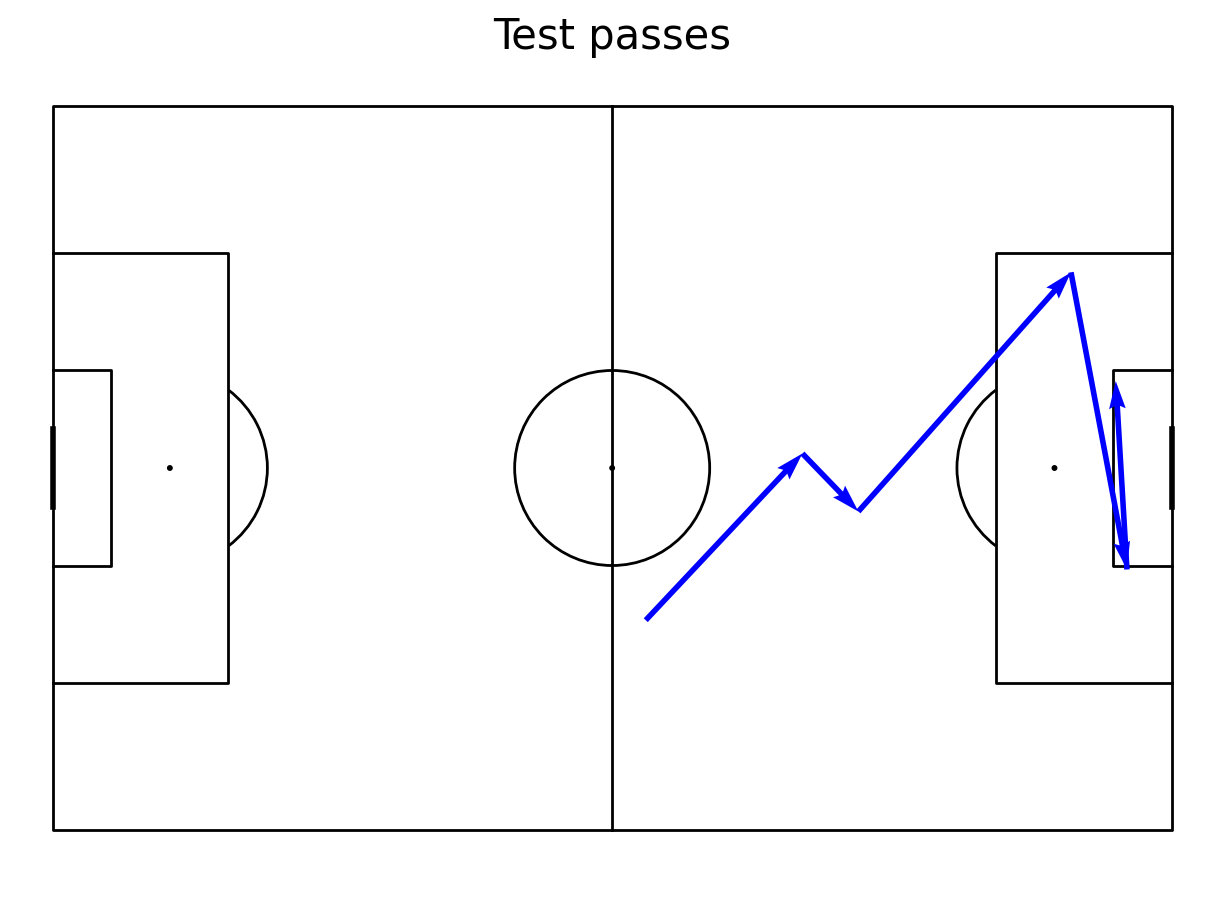

In [11]:
# Plot passes

test = passes[passes["possession_chain"] == 5]

# Init plot
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Plot passes
pitch.arrows(test["x0"], test["y0"], test["x1"], test["y1"], ax=ax["pitch"], color="blue", zorder=3)

ax['title'].text(0.5, 0.5, 'Test passes', ha='center', va='center', fontsize=30)
plt.show()

# Prepare model variables

In [12]:
# Model variables
var = ["x0", "x1", "c0", "c1"]

# Combinations
inputs = []
# One variable combinations
inputs.extend(combinations_with_replacement(var, 1))
# Two variable combinations
inputs.extend(combinations_with_replacement(var, 2))
# Three variable combinations
inputs.extend(combinations_with_replacement(var, 3))

# Make new columns
for i in inputs:
    # Columns length 1 already exist
    if len(i) > 1:
        # Column name
        column = ''
        x = 1
        for c in i:
            # Add column name to be x0x1c0 for example
            column += c
            # Multiply values in column
            x = x*passes[c]

        # Create a new column in passes
        passes[column] = x
        # Add column to model variables
        var.append(column)

# Investigate 3 columns
passes[var[-3:]].head(3)

,c0c0c1,c0c1c1,c1c1c1
0,10.061824,40.247296,160.989184
1,301.854720,565.977600,1061.208000
2,212.241600,42.448320,8.489664


# Logistic regression for shot probability

In [27]:
# Split data into features and labels
X = passes[var].values
y = passes["danger_pass"].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123, stratify = y)

# Initialize XGBoost model
xgb = XGBRegressor(n_estimators = 100, ccp_alpha=0, max_depth=4, min_samples_leaf=10, random_state=123)

# Create DMatrix
dtrain = DMatrix(X_train, label=y_train)

# Get parameters
params = xgb.get_params()

# Use XGBoost's native CV
cv_results = cv(
    params,
    dtrain,
    num_boost_round=100,
    nfold=10,
    early_stopping_rounds=10,
    metrics='rmse'  # or 'mae' depending on your needs
)

# Calculate mean and std of scores
scores = cv_results['test-rmse-mean'].values
print(f"Cross-validation RMSE scores: {scores}")

# Train the model
xgb.fit(X_train, y_train)

# Evaluate the model on the training set
train_score = xgb.score(X_train, y_train)
print(f"Training R² score: {train_score:.3f}")

# Make predictions on the test set
y_pred = xgb.predict(X_test)
test_score = xgb.score(X_test, y_test)
print(f"Test R² score: {test_score:.3f}")

# Calculate additional metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE: {mae:.3f}")

# Show feature importance
feature_importance = pd.DataFrame({
    'feature': var,
    'importance': xgb.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

[02:56:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_ecq5_43q5y/croot/xgboost-split_1712794692543/work/src/learner.cc:767: 
Parameters: { "ccp_alpha", "enable_categorical", "min_samples_leaf", "missing", "n_estimators" } are not used.

[02:56:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_ecq5_43q5y/croot/xgboost-split_1712794692543/work/src/learner.cc:767: 
Parameters: { "ccp_alpha", "enable_categorical", "min_samples_leaf", "missing", "n_estimators" } are not used.

[02:56:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_ecq5_43q5y/croot/xgboost-split_1712794692543/work/src/learner.cc:767: 
Parameters: { "ccp_alpha", "enable_categorical", "min_samples_leaf", "missing", "n_estimators" } are not used.

[02:56:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_ecq5_43q5y/croot/xgboost-split_1712794692543/work/src/learner.cc:767: 
Parameters: { "ccp_alpha", "enable_categorical", "min_samples_leaf", "missing", "n_estim

# Calculating xD

In [36]:
# Predict probability of pass ending in a shot
y_pred_proba = xgb.predict(X)
passes["shot_proba"] = y_pred_proba

passes.head()

# Get passes that ended in a shot
danger_passes = passes[passes["danger_pass"] == 1]

# Init features and labels
X2 = danger_passes[var].values
y2 = danger_passes["xG"].values

# Train linear regression model on X2 and y2
lr = LinearRegression()
lr.fit(X2, y2)

# Use LR model to predict xG for X
y_pred = lr.predict(X)
passes["xG_pred"] = y_pred

# Calculate xD
passes["xD"] = passes["shot_proba"] * passes["xG_pred"]

# Show top 5
passes.head(5)

,index,id,matchId,matchPeriod,minute,second,matchTimestamp,videoTimestamp,relatedEventId,type,...,x1c1c1,c0c0c0,c0c0c1,c0c1c1,c1c1c1,shot_proba,xG_pred,xT,playerId,xD
0,0,2384313747,5588197,1H,0,2,00:00:02.559,3.559115,2.384314e+09,"{'primary': 'pass', 'secondary': ['back_pass',...",...,1149.71136,2.515456,10.061824,40.247296,160.989184,0.029773,0.101965,0.003036,286831,0.003036
1,1,2384313748,5588197,1H,0,4,00:00:04.324,5.324929,2.384314e+09,"{'primary': 'pass', 'secondary': ['lateral_pas...",...,4915.89000,160.989184,301.854720,565.977600,1061.208000,0.031456,0.125499,0.003948,413582,0.003948
2,2,2384313771,5588197,1H,0,6,00:00:06.973,7.973209,2.384314e+09,"{'primary': 'pass', 'secondary': ['lateral_pas...",...,192.26592,1061.208000,212.241600,42.448320,8.489664,0.029028,0.105776,0.003070,551442,0.003070
3,3,2384313772,5588197,1H,0,8,00:00:08.768,9.768278,2.384314e+09,"{'primary': 'pass', 'secondary': ['back_pass',...",...,5348.48832,8.489664,50.937984,305.627904,1833.767424,0.017282,0.129062,0.002230,413582,0.002230
4,4,2384313775,5588197,1H,0,10,00:00:10.769,11.769625,2.384314e+09,"{'primary': 'pass', 'secondary': ['forward_pas...",...,2467.41264,1833.767424,1120.635648,684.832896,418.508992,0.034425,0.126363,0.004350,136441,0.004350


# Rank players

In [37]:
# Get player id
passes["playerId"] = passes["player"].apply(lambda x: x["id"])

# Group value actions by player
player_xD = passes[["playerId", "xD"]].groupby(["playerId"]).sum().reset_index()

# Get player data
